In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles

from geoscripts import gchemplots as gp
from geoscripts import maps

/home/dyvasey/miniconda3/envs/dataset-caucasus-gchem-2023/lib/python3.11/site-packages/mpltern/ternary/datasets.py:9: UserWarning: `mpltern.ternary.datasets.py` has been moved to `mpltern.datasets.py` and will be removed from the present directory in mpltern 0.6.0.
  warnings.warn(msg)


In [2]:
# Read in organized data
data = pd.read_csv('processed/data.csv',index_col=0)

# Filter for J and mafic
filter_period = (data['Period']=='Jurassic')|(data['Period']=='Jurassic?')
filter_major =  (data['SiO2']<57)

data_filtered = data[filter_period&filter_major]

print(data_filtered.index)

Index(['G22032A', 'G22033', 'G22034', 'G22035', 'G22037', 'G22038', 'G22039',
       'G22041A', 'G22041C', 'G22042', 'G22044', 'G22045', 'G22046C', 'G22049',
       'G22051', 'G22053', 'G22063', 'G22065', 'G22066', 'G22067', 'G22068A',
       'G22068B', 'G22068C', 'G22069', 'G22076', 'G22081', 'G22091', 'G22092',
       'G22094', 'G22108A', 'G22109', 'G22118', 'G22119', 'G22126', 'G22141'],
      dtype='object')


In [3]:
# Groups
khaishi_core_smps = ['G22034','G22035','G22037','G22038','G22039']
data_filtered.loc[khaishi_core_smps,'S_Domain'] = 'Khaishi Core'

limb_condition = (~data_filtered.index.isin(khaishi_core_smps)) & (data_filtered['S_Domain'] == 'Khaishi')
data_filtered.loc[limb_condition,'S_Domain'] = 'Khaishi Limbs'

group_dict = {'Khaishi Core':'Khaishi Core','Khaishi Limbs':'Khaishi Limbs','Idliani':'Idliani','Jvari':'Jvari','Lentekhi':'Lentekhi/Panaga','Mazashi':'Mazashi','Panaga':'Lentekhi/Panaga',
              'Tsageri-Khvamli':'Tsageri-Khvamli','Dzirula':np.nan,'Pasanauri':np.nan}

chem_group = [group_dict[x] for x in data_filtered['S_Domain']]

groups = data_filtered.groupby(chem_group)

In [4]:
# Group properties
axes_dict = {'Khaishi Core':(0,0),'Khaishi Limbs':(0,0),'Idliani':(1,0),'Jvari':(2,0),'Lentekhi/Panaga':(0,1),'Mazashi':(1,1),'Tsageri-Khvamli':(2,1)}

color_dict = {'Khaishi Core':'#88CCEE','Khaishi Limbs':'#44AA99','Idliani':'#117733','Jvari':'#999933','Lentekhi/Panaga':'#AA4499','Mazashi':'#882255','Tsageri-Khvamli':'#CC6677'}

# color_dict = {'Khaishi Core':'#762A83','Khaishi Limbs':'#9970AB','Idliani':'#C2A5CF','Jvari':'#E7D4E8','Lentekhi/Panaga':'#1B7837','Mazashi':'#5AAE61','Tsageri-Khvamli':'#ACD39E'}

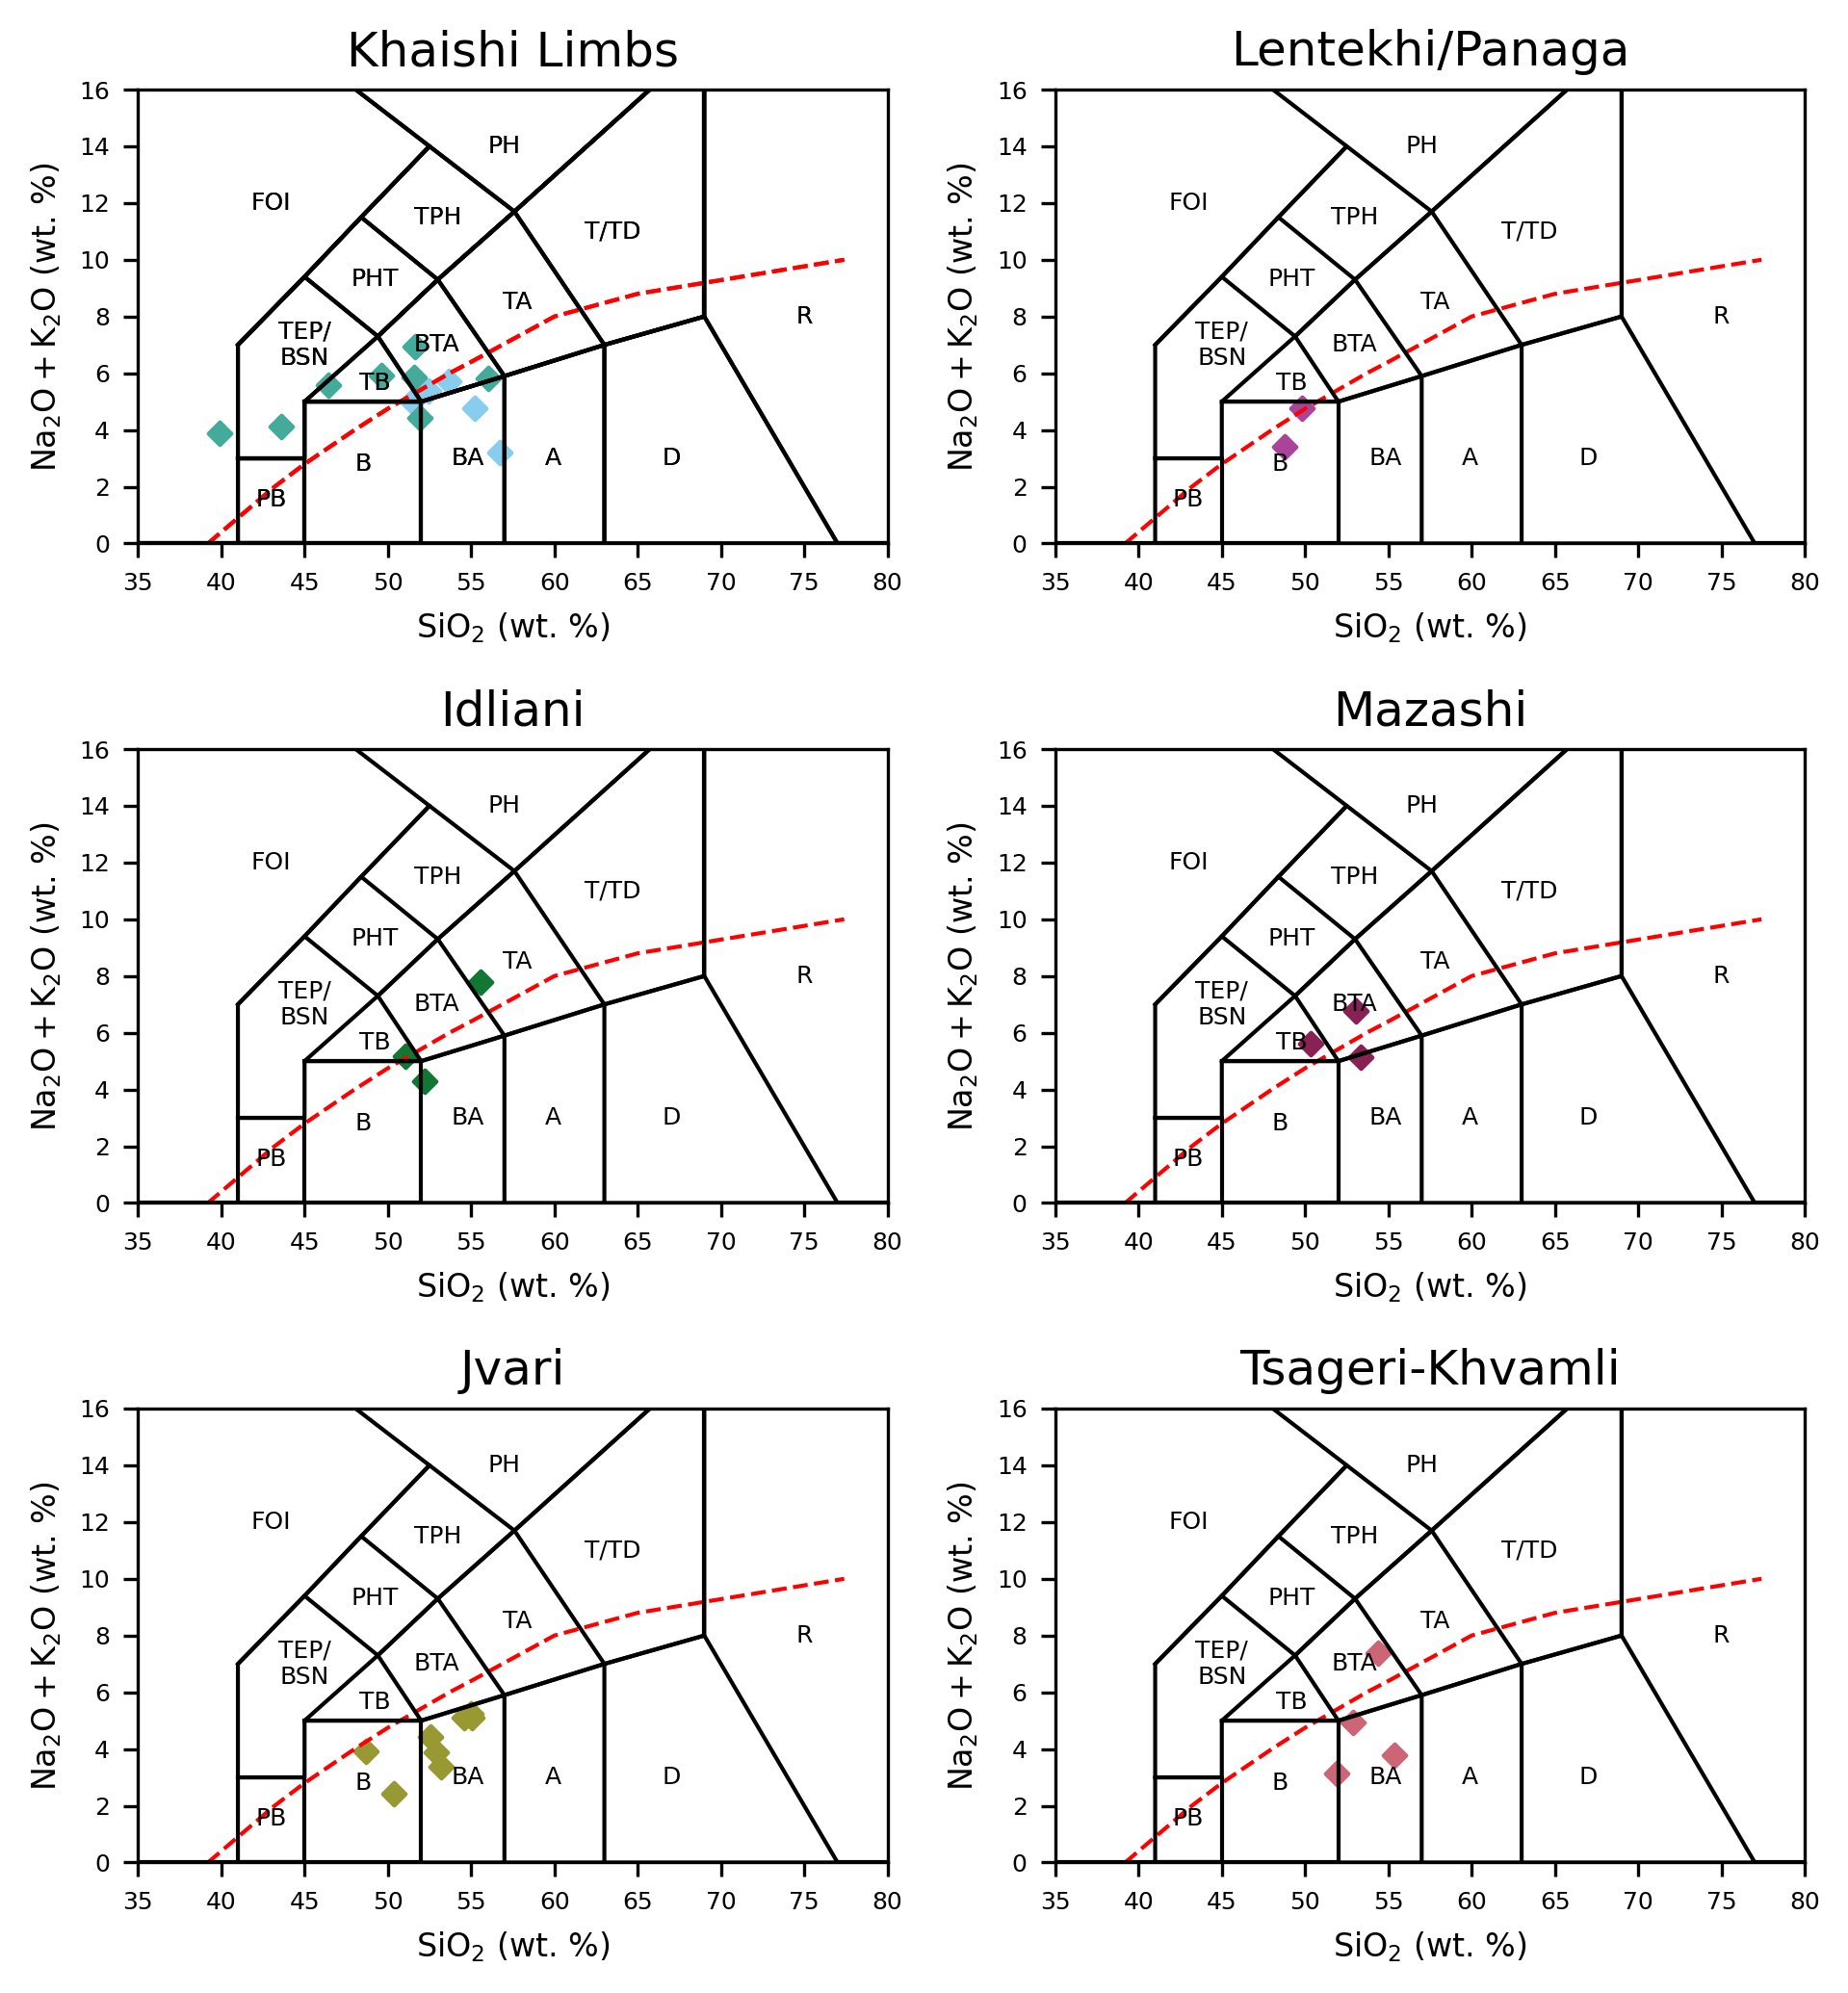

In [5]:
# Majors
fig,axs = plt.subplots(3,2,dpi=300,figsize=(6.5,7))

for k, group in groups:
    ax = axs[axes_dict[k]]
    color = color_dict[k]
    SiO2,Na2O,K2O = group[['SiO2','Na2O','K2O']].T.values
    gp.TASsm(SiO2,Na2O,K2O,label=k,ax=ax,color=color,first=[])
    ax.set_title(k)

plt.tight_layout()
fig.savefig('TAS.pdf')

In [6]:
# Harkers

for k, group in groups:
    fig,axs = plt.subplots(4,2,figsize=(6.5,9),dpi=300)
    fig.suptitle(k)
    harker_cols = group.columns.str.replace('*','t')
    data_harker = group.copy()
    data_harker.columns = harker_cols

    gp.harker(data_harker,fig=fig,axs=axs,color=color_dict[k])
    fig.savefig(k[0:3]+'_harker.pdf')
    plt.close()

/tmp/ipykernel_56923/4135277328.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  harker_cols = group.columns.str.replace('*','t')
/tmp/ipykernel_56923/4135277328.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  harker_cols = group.columns.str.replace('*','t')
/tmp/ipykernel_56923/4135277328.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  harker_cols = group.columns.str.replace('*','t')
/tmp/ipykernel_56923/4135277328.py:6: FutureWarning: The default value of regex will change from True to False in a future vers

4
4
4
4
4
4
4


/home/dyvasey/miniconda3/envs/dataset-caucasus-gchem-2023/lib/python3.11/site-packages/pyrolite/plot/spider.py:270: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniconda3/envs/dataset-caucasus-gchem-2023/lib/python3.11/site-packages/pyrolite/plot/spider.py:270: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniconda3/envs/dataset-caucasus-gchem-2023/lib/python3.11/site-packages/pyrolite/plot/spider.py:270: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniconda3/envs/dataset-caucasus-gchem-2023/lib/python3.11/site-packages/pyrolite/plot/spider.py:270: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniconda3/envs/dataset-caucasus-gchem-2023/lib/python3.11/site-packages/p

4
4
4
4
4
4
4


/home/dyvasey/miniconda3/envs/dataset-caucasus-gchem-2023/lib/python3.11/site-packages/pyrolite/plot/spider.py:270: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniconda3/envs/dataset-caucasus-gchem-2023/lib/python3.11/site-packages/pyrolite/plot/spider.py:270: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniconda3/envs/dataset-caucasus-gchem-2023/lib/python3.11/site-packages/pyrolite/plot/spider.py:270: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniconda3/envs/dataset-caucasus-gchem-2023/lib/python3.11/site-packages/pyrolite/plot/spider.py:270: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniconda3/envs/dataset-caucasus-gchem-2023/lib/python3.11/site-packages/p

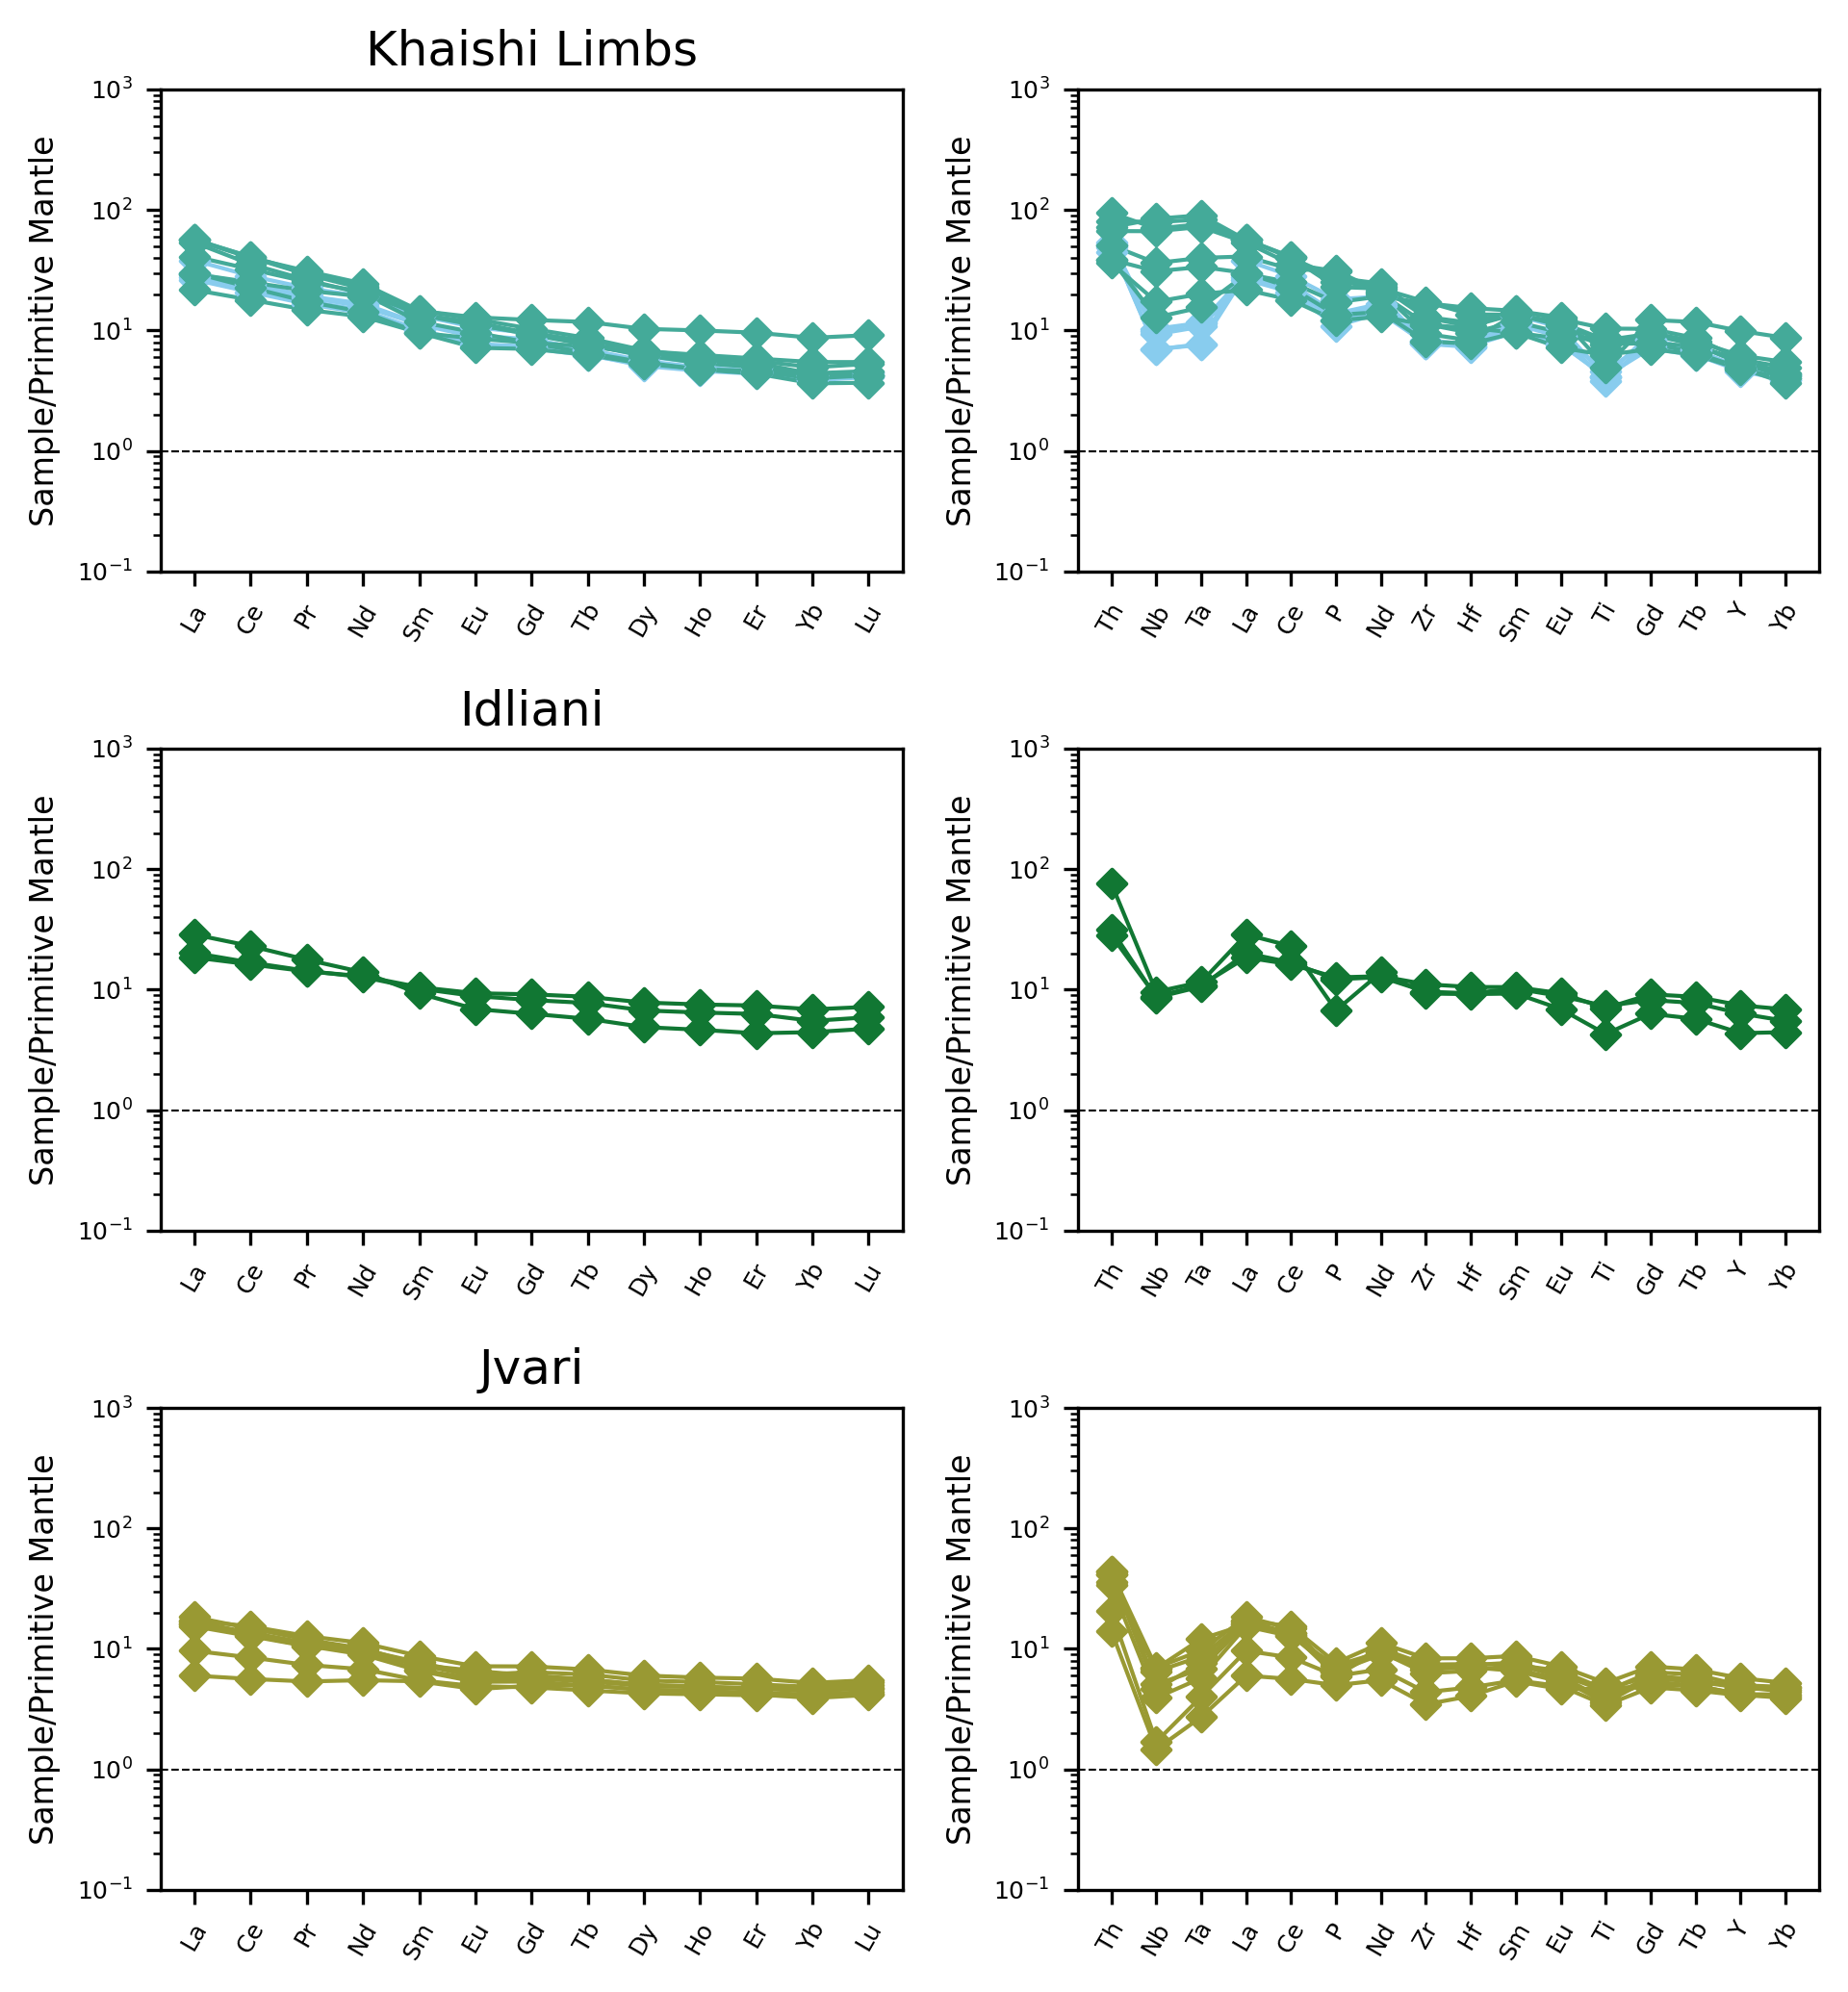

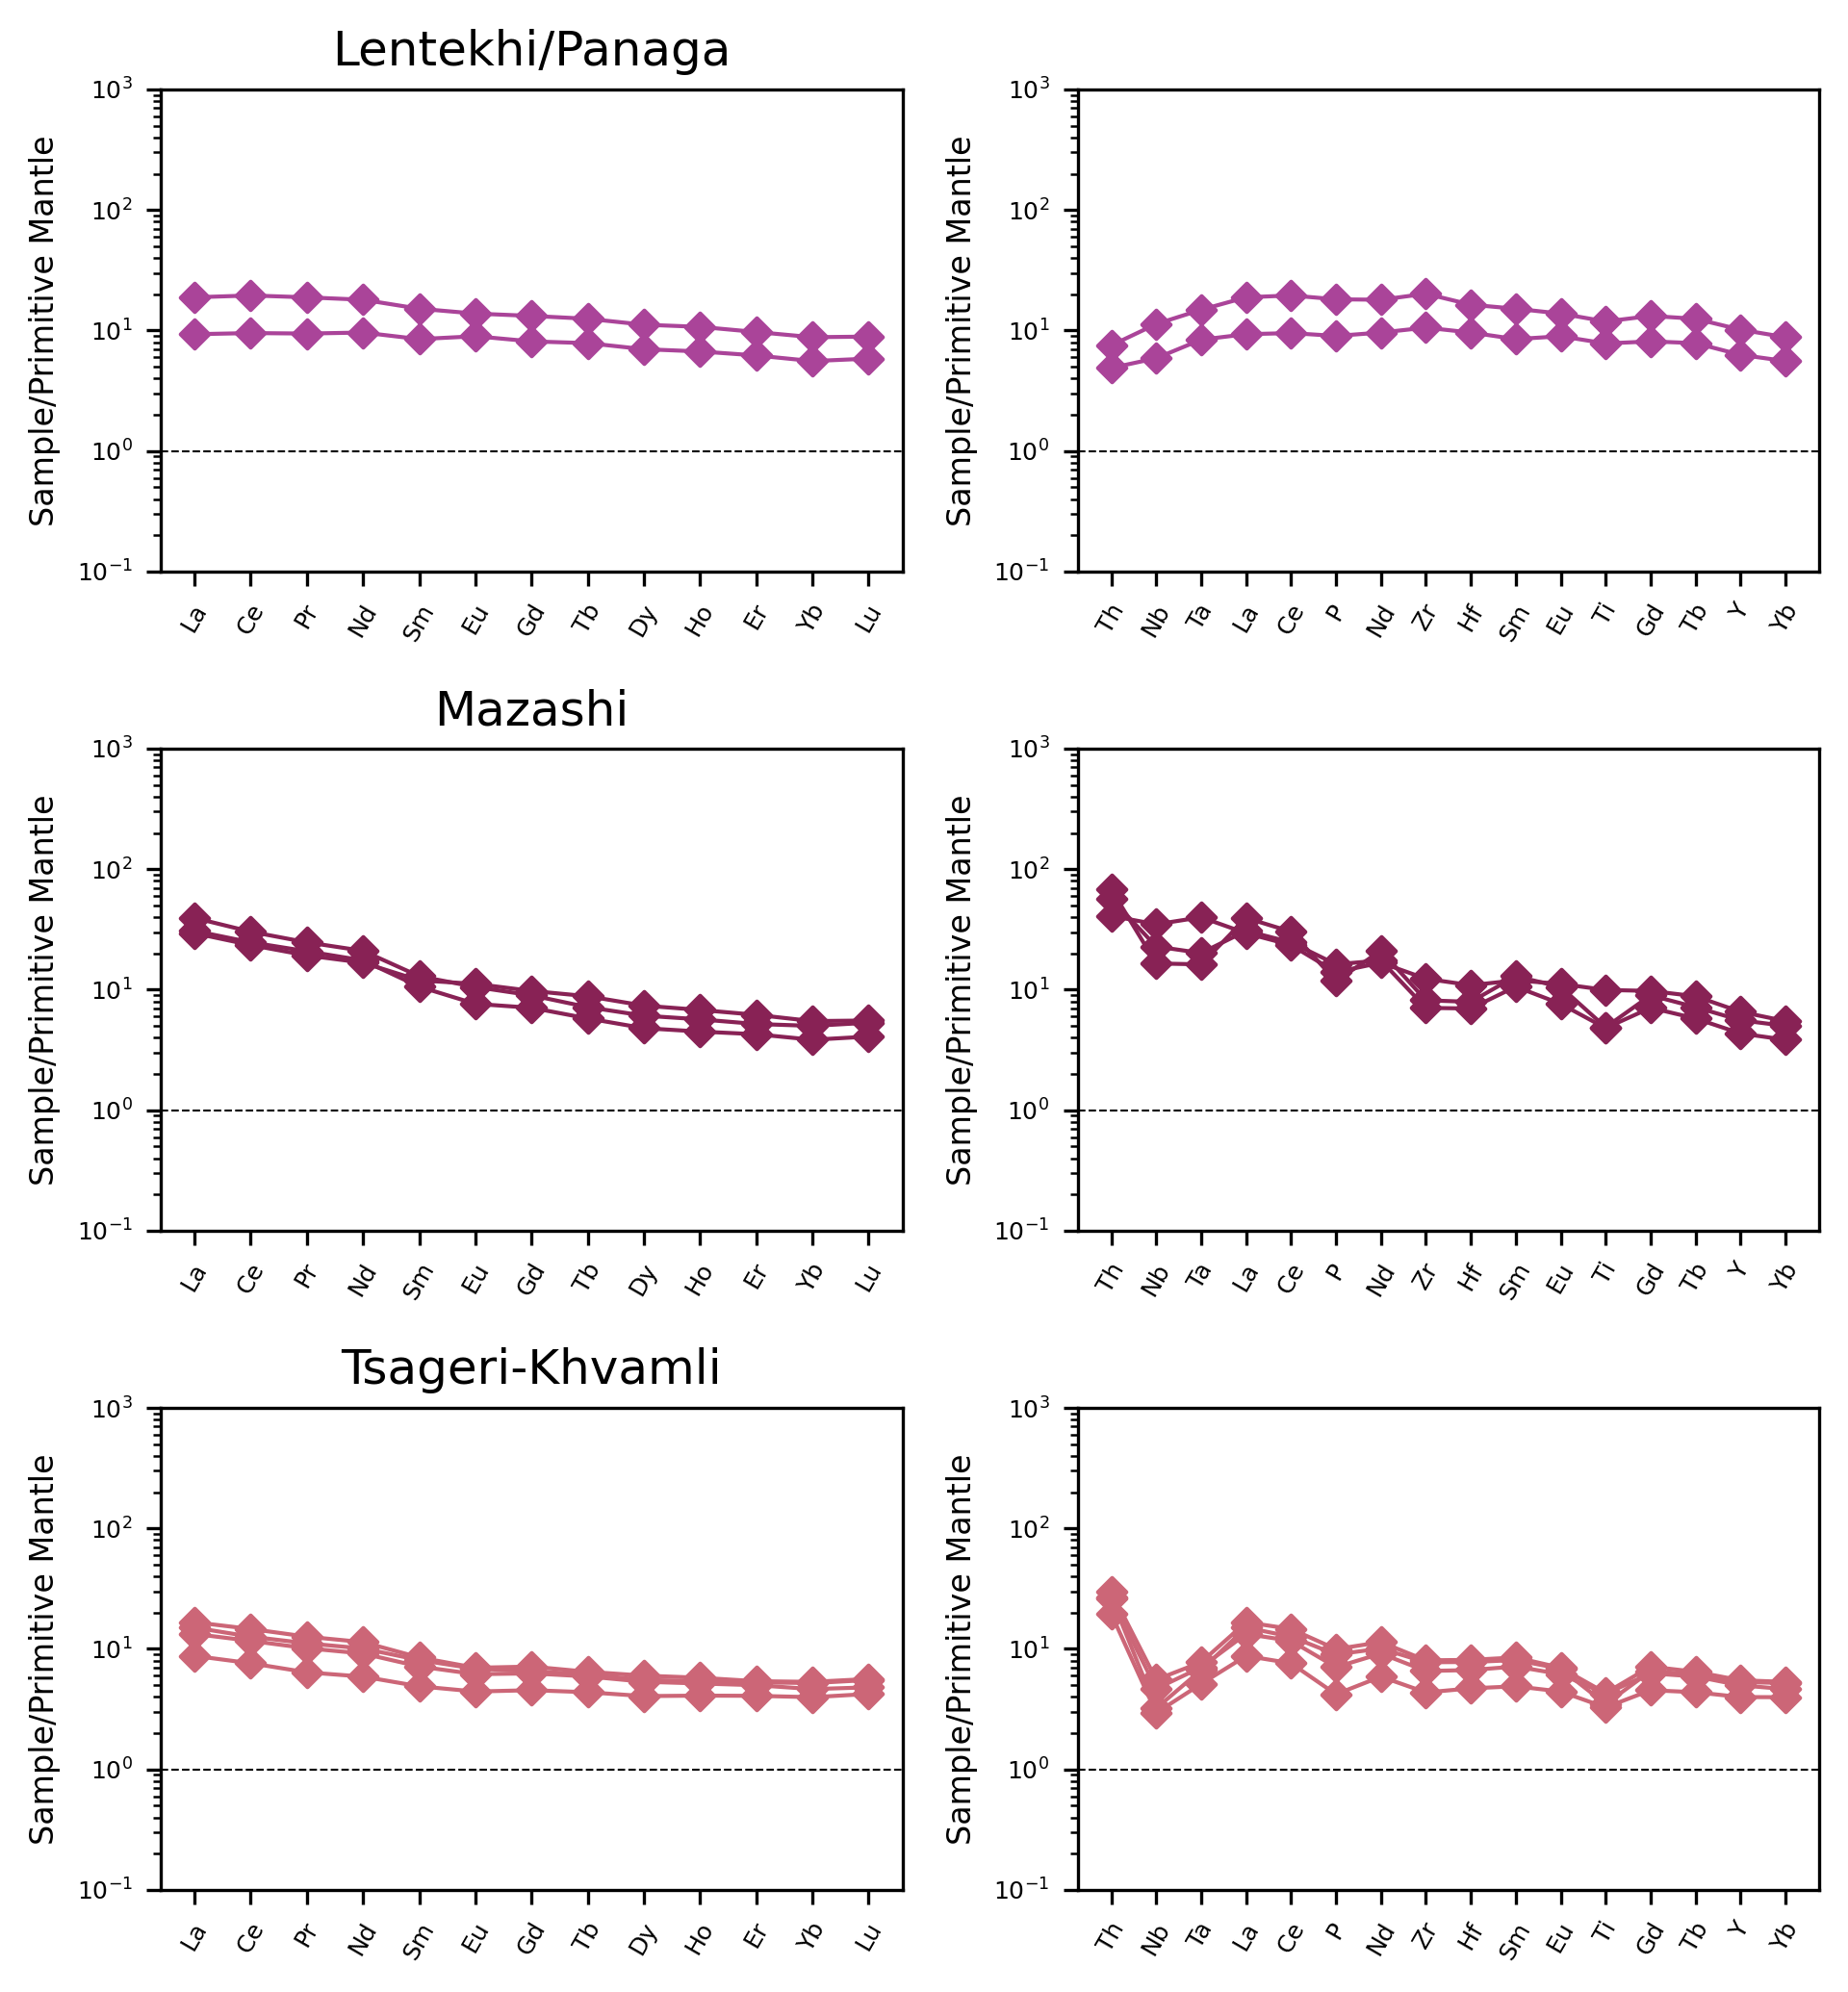

In [7]:
# Spiders

fig0,axs0 = plt.subplots(3,2,figsize=(6.5,7),dpi=300)

fig1,axs1 = plt.subplots(3,2,figsize=(6.5,7),dpi=300)


axs_all = [axs0,axs1]

for k, group in groups:
    fignum = axes_dict[k][1]
    axs = axs_all[fignum]

    ax0 = axs[(axes_dict[k][0],0)]
    ax1 = axs[(axes_dict[k][0],1)]

    ax0.set_title(k)

    gp.REE(group,ax=ax0,c=color_dict[k])
    gp.immobile(group,ax=ax1,c=color_dict[k])

fig0.set_layout_engine('tight')
fig1.set_layout_engine('tight')

fig0.savefig('west_spiders.pdf')
fig1.savefig('east_spiders.pdf')



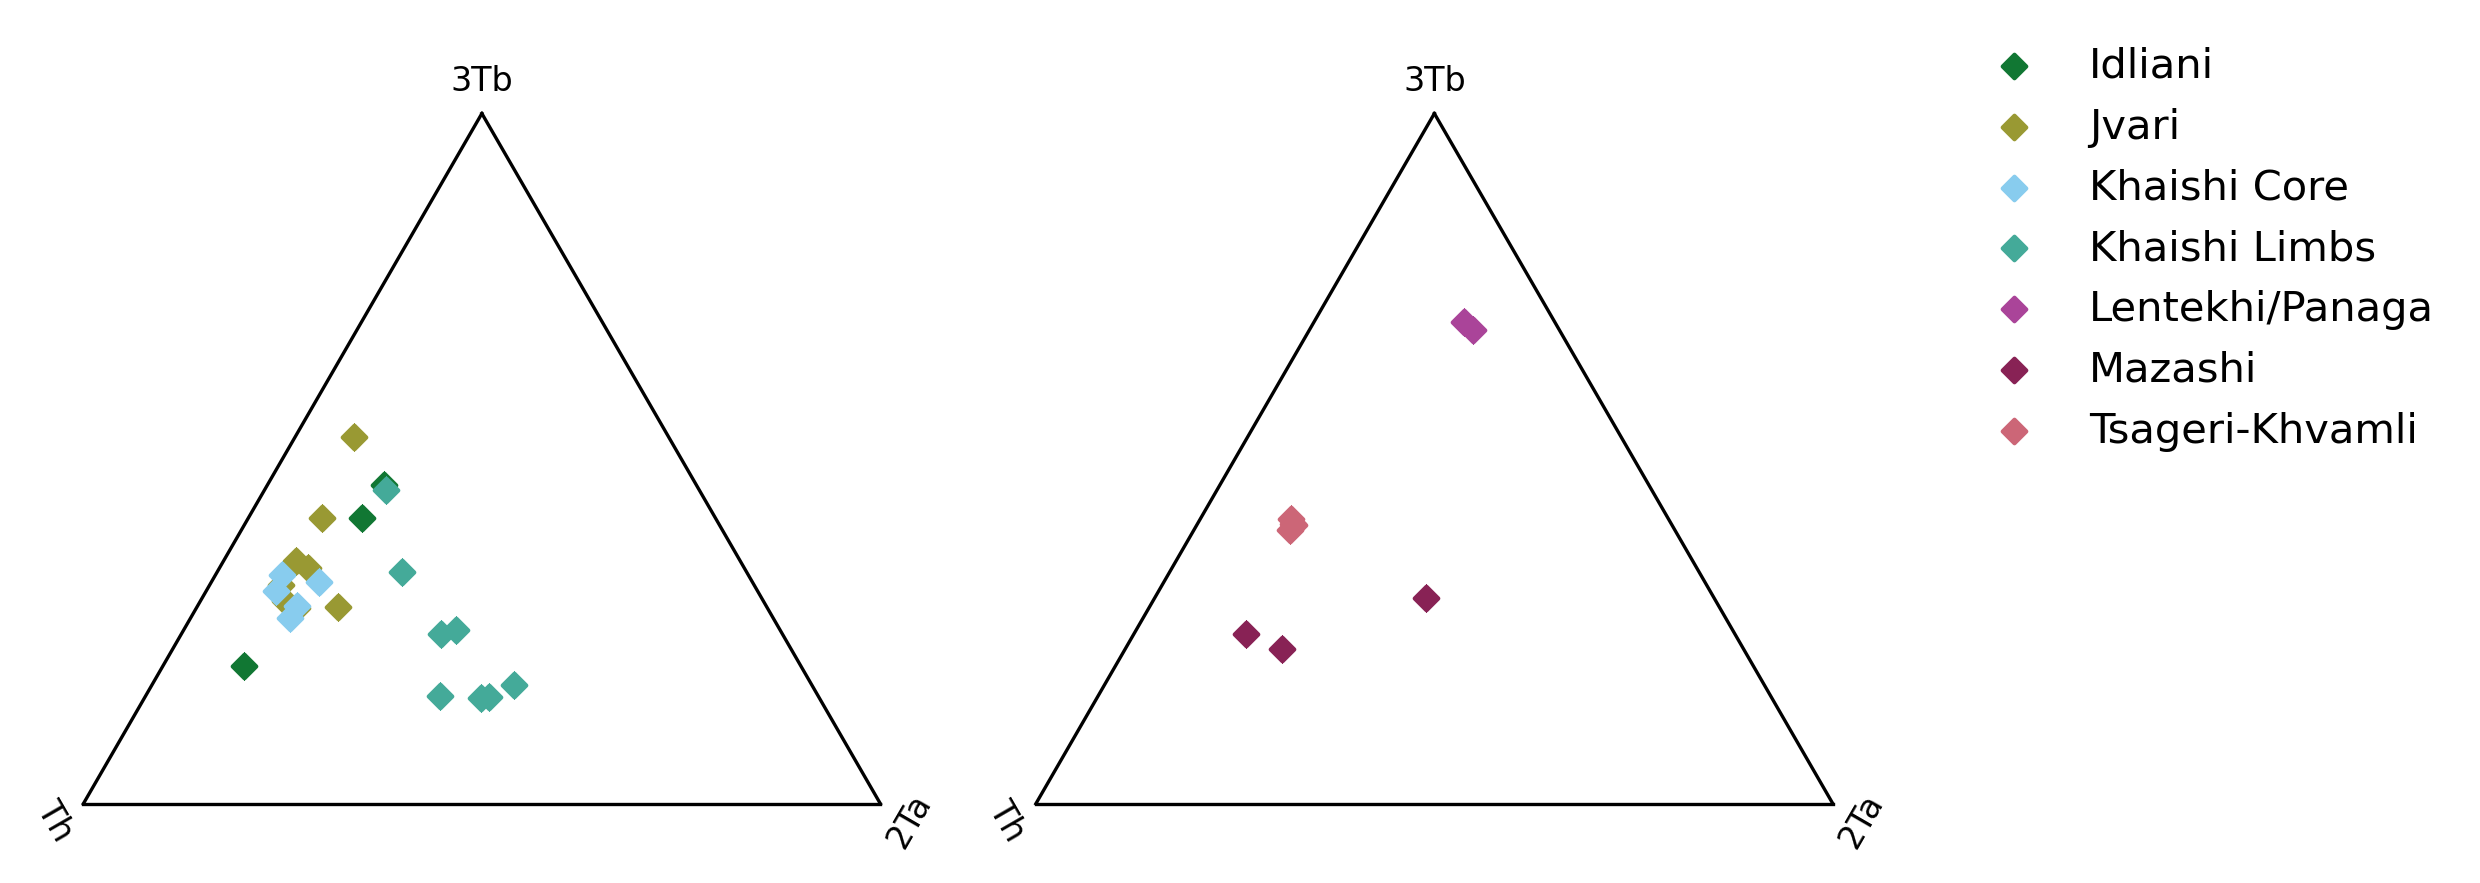

In [8]:
# Ternary
fig = plt.figure(figsize=(6.5,3),dpi=300)
ax0 = fig.add_subplot(121,projection='ternary')
ax1 = fig.add_subplot(122,projection='ternary')
axs = [ax0,ax1]

for k,group in groups:
    ax = axs[axes_dict[k][1]]
    Tb,Th,Ta = group[['Tb','Th','Ta']].T.values
    gp.cabanis(Tb,Th,Ta,ax=ax,label=k,c=color_dict[k])

fig.legend()
plt.tight_layout()
fig.savefig('ternary.pdf')

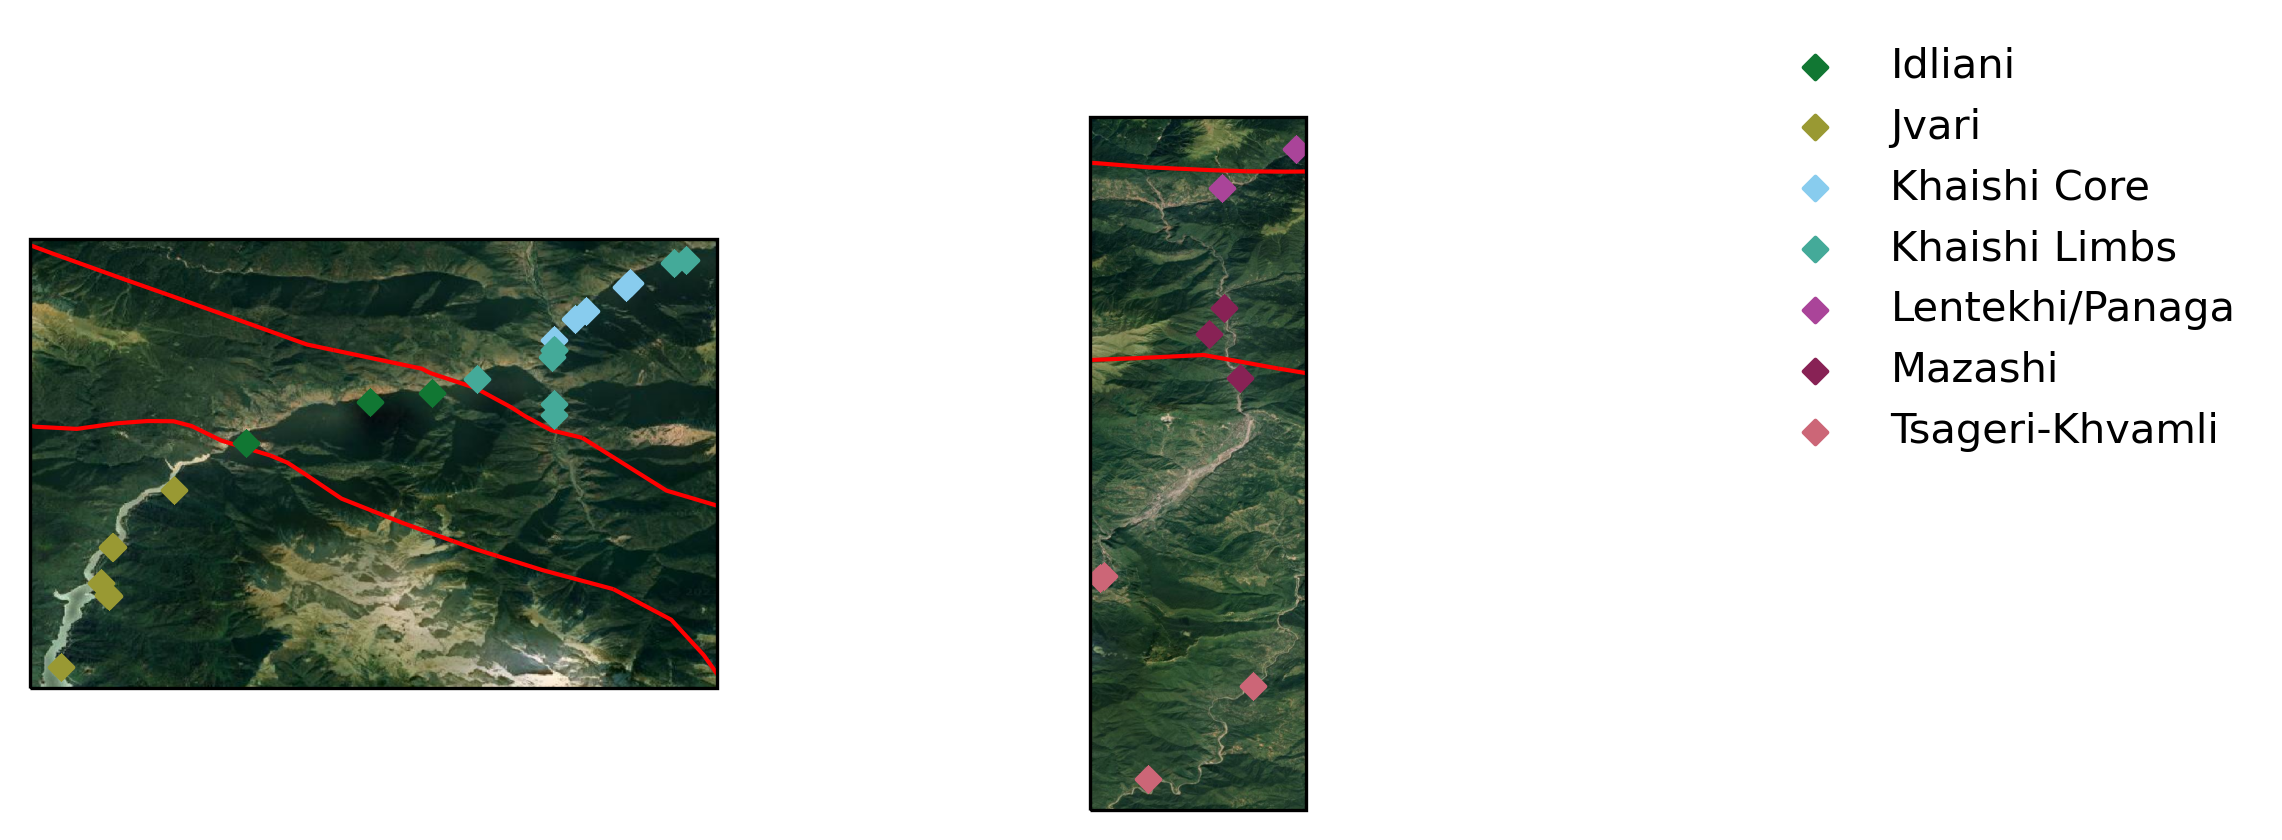

In [21]:
# Locations
img = GoogleTiles(style='satellite')

fig = plt.figure(figsize=(6.5,3),dpi=300)
ax0 = fig.add_subplot(121,projection=ccrs.PlateCarree())
ax1 = fig.add_subplot(122,projection=ccrs.PlateCarree())

axs = [ax0,ax1]

for ax in axs:
    ax.add_image(img,12)
    maps.shpplt_simple(shp='map_data/gc_majorfaults_wgs84.shp',edgecolor='red',
                    facecolor='None',zorder=1,ax=ax)

for k, group in groups:
    ax = axs[axes_dict[k][1]]
    ax.scatter(group['Longitude'],group['Latitude'],c=color_dict[k],label=k)
    # for index,row in group.iterrows():
    #    ax.annotate(index,(row['Longitude'],row['Latitude']))



fig.legend()
fig.savefig('locations.pdf')